In [31]:
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

Datavoorbereiding

In [3]:
def aanmakenDf (groep, label):
#Twee lege lijsten worden aangemaakt die dan uiteindelijk samen dataframe zullen vormen 
    Pixels= []
    Label =[]
  
#fotos inlezen en omzetten per groep. 
    for foto in os.listdir(groep):
        beeld = Image.open(groep+foto)
#fotos omzetten in grijswaarde of 2 dimensionele array ipv 3x2
        beeld_grijs = ImageOps.grayscale(beeld)

#fotos resizen voor leesbaarheid tijdens testen, en eventueel voor latere experimenten
        beeld_formaat = beeld_grijs.resize((beeld_grijs.width // 1, beeld_grijs.height //1 ))       
        
#fotos omzetten naar numpy array
        data_2dim = np.asarray(beeld_formaat, dtype=np.uint8)
        data = data_2dim.flatten()

#3 lijsten opvullen, eerste met data van foto, tweede met label en derde met naam van foto. 
#De lengte van elke lijst = aantal fotos in bijhorende map
        Pixels.append(data)
        Label.append(label)

#Per groep worden de drie aangemaakte lijsten omgezet naar panda df
# BDP: we hebben naam niet nodig om te trainen, enkel pixels en labels => verwijder

    dict = {'data': Pixels, 'label': Label}
    df = pd.DataFrame(dict)
    return df

In [4]:
#Dataframe aanmaken
aanwezig = r"classificatie/aanwezig/"  #852 foto's 
buiten = r"classificatie/buiten/"       #389 foto's
niets = r"classificatie/niets/"         #1399 foto's
#Eerst wordt per map een panda dataframe aangemaakt
nietsDf = aanmakenDf(niets, 0)
aanwezigDf = aanmakenDf(aanwezig, 1)
buitenDf = aanmakenDf(buiten, 2)
#vervolgens worden ze alle drie samengevoegd tot 1 groot dataframe
volledigDataframe = pd.concat([nietsDf, aanwezigDf, buitenDf], ignore_index=True)

In [5]:
#Opsplitsen in gestratificieerde testset en trainingsset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(volledigDataframe, volledigDataframe['label']):
    strat_train_set = volledigDataframe.loc[train_index]
    strat_test_set = volledigDataframe.loc[test_index] 
#X = data, y = label. Dit voor trainingsset en testset

X_train, X_test, y_train, y_test = strat_train_set['data'], strat_test_set['data'], strat_train_set['label'], strat_test_set['label']

In [6]:
#Omzetten naar np.array
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [24]:
#Schalen van de pixel arrays
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_array.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test_array.astype(np.float64))

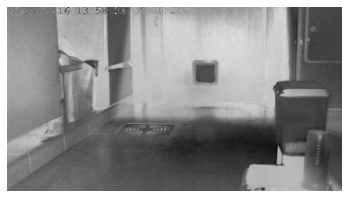

In [25]:
#Testfoto voor modellen, gescaled en terug omgezet naar beeld
image = X_train_scaled[0].reshape(352, 640)
plt.imshow(image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

Trainen verschillende modellen

In [26]:
# sgd
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_scaled, y_train_array)
sgd_clf.predict([X_train_scaled[0]])

array([0], dtype=int64)

In [35]:
#cross validation score
cross_val_score(sgd_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.91761364, 0.92897727, 0.91903409])

In [27]:
#OvO classifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train_array, y_train_array)
ovo_clf.predict([X_train_scaled[0]])

array([1], dtype=int64)

In [36]:
#cross validation score
cross_val_score(ovo_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.921875  , 0.92613636, 0.93039773])

In [28]:
#RandomforestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_scaled, y_train_array)
forest_clf.predict([X_train_scaled[0]])

array([0], dtype=int64)

In [37]:
#cross validation score
cross_val_score(forest_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.94034091, 0.94886364, 0.93465909])

In [29]:
# svm
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_scaled, y_train_array)
svm_clf.predict([X_train_scaled[0]])

array([0], dtype=int64)

In [40]:
#cross validation score
cross_val_score(svm_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.93465909, 0.92897727, 0.93039773])

In [30]:
#Votingclassifier  
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('forest', forest_clf), ('ovo', ovo_clf), ('ova', sgd_clf), ('svm', svm_clf)],voting='hard')
voting_clf.fit(X_train_scaled, y_train_array)
voting_clf.predict([X_train_scaled[0]])

array([0], dtype=int64)

In [39]:
#cross validation score
cross_val_score(voting_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.92897727, 0.94176136, 0.92755682])

In [34]:
#Accuuraatheid van de verschillede modellen op test array
from sklearn.metrics import accuracy_score
for clf in (sgd_clf, ovo_clf, forest_clf, svm_clf, voting_clf):
 clf.fit(X_train_scaled, y_train_array)
 y_pred = clf.predict(X_test_scaled)
 print(clf.__class__.__name__, accuracy_score(y_test_array, y_pred))

SGDClassifier 0.9299242424242424
OneVsOneClassifier 0.8939393939393939
RandomForestClassifier 0.9431818181818182
SVC 0.9261363636363636
VotingClassifier 0.9375


Modelselectie en finetuning

In [33]:
#Opvragen parameters van randomforest classifier en imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
#Opzoeken welke parameters invloed hebben op accuuraatheid. 
param_grid = { 
    'n_estimators': [5, 10, 100, 300, 500, 800],  #controleert het aantal bomen in de classifier ; standaard 100
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None,5,8, 20],  #Bepaalt de hoogte tot waar een boom kan groeien, één van de belangrijkste parameters naar accuracy toe.
                                #Let op: Niet hoe meer, hoe beter, maar uitkijken voor overfitting. Standaard: none, wat betekent dat ze blijven groeien tot bladeren puur zijn
    'min_samples_split' : [2,5,20,50,200],
    'min_samples_leaf': [1,100,300,500,800],
    'max_leaf_nodes' : [None,5,8, 20,50],  #Helpt om max depth te beperken en dus om overfittig tegen te gaan. 
}    

In [42]:
#Eerst veel verschillende waarden met randomsearch
CV_forest_clf = RandomizedSearchCV(forest_clf, param_grid, n_iter=1000, cv=3, verbose = 2)
CV_forest_clf.fit(X_train_scaled, y_train_array)
CV_forest_clf.best_estimator_.get_params()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.3min
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.3min
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 1.3min
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=200, n_estimators=5; total time=   3.1s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=200, n_estimators=5; total time=   3.0s
[CV] END max_depth=None, max_features=auto, max_leaf_nodes=20, min_samples_leaf=1, min_samples_split=200, n_estimators=5; total time=   3.0s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=100, min_samples_s

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Model met parameters op basis van randomsearch
random_forest_clf = RandomForestClassifier(random_state=42, min_samples_split =  5,n_estimators= 500, max_leaf_nodes = 50)
random_forest_clf.fit(X_train_scaled , y_train_array)


In [44]:
#nauwere parameters op basis van random search
parameters = { 
    'n_estimators': [400,500,600,700],  #controleert het aantal bomen in de classifier ; standaard 100
    'min_samples_split' : [3,5,8,10],
    'max_leaf_nodes' : [40,50,60,70],  #Helpt om max depth te beperken en dus om overfittig tegen te gaan. 
}

In [45]:
#Beste parametes op basis van gridsearch
grid_forest_clf = GridSearchCV(forest_clf,parameters,cv=5, verbose=2)
grid_forest_clf.fit(X_train_scaled, y_train_array)
grid_forest_clf.best_estimator_.get_params()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=400; total time= 2.0min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=400; total time= 2.1min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=400; total time= 2.0min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=400; total time= 2.0min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=400; total time= 2.0min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=500; total time= 2.4min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=500; total time= 2.5min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=500; total time= 2.5min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=500; total time= 2.4min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=500; total time= 2.4min
[CV] END max_leaf_nodes=40, min_samples_split=3, n_estimators=600; total time=

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 60,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [47]:
#Model met parameters op basis van gridsearch
grid_forest_clf = RandomForestClassifier(random_state=42, min_samples_split = 8,n_estimators= 700, max_leaf_nodes = 60)
grid_forest_clf.fit(X_train_scaled , y_train_array)

RandomForestClassifier(max_leaf_nodes=60, min_samples_split=8, n_estimators=700,
                       random_state=42)

In [48]:
#Vergelijken accuuraatheid forest_clf, random_forest_clf en grid_forest_clf
for clf in (grid_forest_clf, random_forest_clf, forest_clf):
 clf.fit(X_train_scaled , y_train_array)
 y_pred = clf.predict(X_test_scaled)
 print(clf.__class__.__name__, accuracy_score(y_test_array, y_pred))

RandomForestClassifier 0.946969696969697
RandomForestClassifier 0.946969696969697
RandomForestClassifier 0.9431818181818182


Error Analyse op meest accurate model

In [49]:
#Confusion matrix voor forestClassifier
#rijen zijn gegeven klasses, kolommen voorspelde
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
best_forest_clf = grid_forest_clf
y_test_forestPred = cross_val_predict(best_forest_clf, X_test_scaled, y_test_array, cv=3)
conf_mx = confusion_matrix(y_test_array, y_test_forestPred)
print (conf_mx)
cr = classification_report(y_test_array, y_test_forestPred)
print (cr)

[[265  15   0]
 [ 21 138  11]
 [  5  10  63]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       280
           1       0.85      0.81      0.83       170
           2       0.85      0.81      0.83        78

    accuracy                           0.88       528
   macro avg       0.87      0.86      0.86       528
weighted avg       0.88      0.88      0.88       528



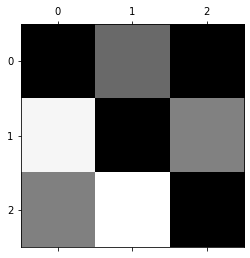

In [50]:
#confusion matrix figuur
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [55]:
#class weight toevoegen aan model. In ons geval meer gewicht aan klasse 2!
#Berekening class weight: Totaal cases / aantal klasses * cases in klasse
#Algemene accuuraatheid daalt wel
gewogen_forest_clf = RandomForestClassifier(random_state=42, min_samples_split = 8,n_estimators= 700, max_leaf_nodes = 60, class_weight = {0: 0.62, 1: 1.16, 2: 4.25})
gewogen_forest_clf.fit(X_train_scaled , y_train_array)
y_pred_gewogen = gewogen_forest_clf.predict(X_test_scaled)
print(clf.__class__.__name__, accuracy_score(y_test_array, y_pred_gewogen))

RandomForestClassifier 0.9412878787878788


In [52]:
#Confusion matrix voor gewogen forestClassifier
#rijen zijn gegeven klasses, kolommen voorspelde
#Recall van groep 2 is beter => hij zal deze beter 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test_forestPred = cross_val_predict(gewogen_forest_clf, X_test_scaled, y_test_array, cv=3)
conf_mx = confusion_matrix(y_test_array, y_test_forestPred)
print (conf_mx)
cr = classification_report(y_test_array, y_test_forestPred)
print (cr)

[[263  17   0]
 [ 28 129  13]
 [  4   9  65]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       280
           1       0.83      0.76      0.79       170
           2       0.83      0.83      0.83        78

    accuracy                           0.87       528
   macro avg       0.85      0.84      0.85       528
weighted avg       0.86      0.87      0.86       528



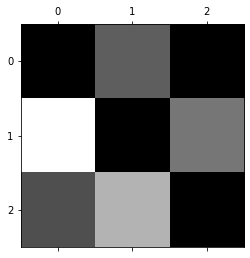

In [53]:
#confusion matrix figuur
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Model dat zal worden gebruikt in app

In [17]:
#Hier kan worden gekozen tussen beste best_forest_clf met verbeterde parameters, of
#gewogen_forest_clf met de verbeterde parameters en aangepaste gewichten (meer voo groep,; meest voor groep 2)
import joblib
joblib.dump(best_forest_clf, "models/final_model.pkl")


['models/final_model.pkl']